# Задача

**Содержание**<a id='toc0_'></a>    
- [Посмотрим на данные](#toc1_)    
  - [Первое приближение](#toc1_1_)    
  - [По финальному коду обработки](#toc1_2_)    
  - [По времени и камерам](#toc1_3_)    
  - [По алфавиту](#toc1_4_)    
- [Модель](#toc2_)    
  - [Выделим целевой класс](#toc2_1_)    
- [Решение](#toc3_)    
  - [Проверка](#toc3_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Описание ситуации:**
Существует процесс обработки нарушений, формируемых камерами фото и видео фиксации. Камеры детектируют различные нарушения и формируют материалы нарушения, при этом распознают номерной знак (ГРЗ, государственный регистрационный знак) транспортного средства (ТС). После этого все нарушения анализируются компетентным сотрудником (оператором) и принимается решение: оформить нарушение, или забраковать с некоторой причиной. В случае если ГРЗ распознан камерой неверно, то по нарушению получены не корректные данные о собственнике и сотрудник может изменить ГРЗ и получить корректные данные, что требует дополнительных сил и времени от сотрудника.  

В существующий процесс внедрен дополнительный механизм обработки изображения ГРЗ другим математическим алгоритмом до того как материал будет передан оператору, ожидается, что использование ГРЗ от нового алгоритма позволит уменьшить кол-во замен ГРЗ оператором.

**Цель:**  

Минимизировать трудозатраты сотрудников по замене ГРЗ  

Для этого необходимо:  
1. Сформировать правило (определить условия) по которому нужно изменять ГРЗ с распознанного камерой, на распознанный новым математическим аппаратом.  
2. Указать и обосновать критерии корректности замены ГРЗ.  
3. Оценить качество работы правила, указать экономию операций по замене ГРЗ.  

Описание полей данных:  
- `id`              - идентификатор нарушения     
- `camera_id`       - идентификатор камеры сформировавшей нарушение   
- `time_check`      - время фиксации нарушения   
- `regno_recognize` - ГРЗ распознанный камерой   
- `regno_ai`        - ГРЗ распознанный новым математическим алгоритмом   
- `regno`           - ГРЗ в итоге процесса обработки нарушения (по умолчанию он равен regno_recognize, если не изменялся оператором)   
- `result_code`     - финальный код результата обработки нарушения (подробная расшифровка ниже)   
- `symbols`         - ГРЗ распознанный новым математическим алгоритмом, по символьно   
- `symbol_scores`   - скор уверенности нового мат. алгоритма по каждому символу из symbols (значения от 0 до 1)   
- `length_scores`   - скор уверенности длинны ГРЗ нового мат. алгоритма начиная с длинны 0, и до длинны 10 символов (значения от 0 до 1)   

Расшифровка `result_code`:  
- `0` - оформлено  
- `1` - забраковано по причине "плохо виден ГРЗ"  
- `2` - забраковано по причине "ошибка в адресе собственника"  
- `3` - забраковано по причине "ошибка в иных данных собственника"  
- `4` - забраковано по причине "плохое качество изображения"  
- `5` - забраковано по причине "иное"  

# Решение

1. Правило состоит в замене ГРЗ на распознанный новым алгоритмом, когда **в распознанном старым алгоритмом ГРЗ отсутствует паттерн ГРЗ "прицепа"** (4 цифры 2 буквы 2 цифры).  
2. Это обусловлено тем, что в целом более эффективный новый алгоритм, допускает в 28 раз больше ошибок в таких ГРЗ, чем старый алгоритм.   
3. Качество работы такого правила - экономия 58.22 операций по ручному уточнению ГРЗ по сравнению с старым алгоритмом (в расчете на 1000 оформленых нарушений) или относительное снижение в 23,77 раза.  

Показатель точности и вероятность ошибки такого правила:  

$$p = 0.99744$$

$$q = 0.00256$$


## <a id='toc1_'></a>[Посмотрим на данные](#toc0_)


In [1]:
suppressMessages(library(ggplot2))
suppressMessages(library(dplyr))
suppressMessages(library(data.table))

options(repr.plot.width=10, repr.plot.height=7)

DATA <- "./data/test_data_regno.csv"
data <- fread(DATA)

### <a id='toc1_1_'></a>[Первое приближение](#toc0_)
  
Будем обозначать   
- `ai` - новый алгоритм,   
- `cam` - старый алгоритм,   
- `op` - оператор  
  
Рассмотрим для началa только коды `result_code = 0`.  
  
Всего 194214 наблюдения. Из них оформлено нарушений 135289 (69.7%).   
  
Если решения оператора (`op`) по оформлению нарушения считаем безошибочными (`gt`), то:  
  
- 126174 раз `ai` верно распознал вместе с `cam`  
- 8007 раз `ai` верно исправил `cam`  
- 892 раз `ai` ошибочно исправил `cam`  
- 189 раз `ai` и `cam` ошиблись каждый по-своему  
- 27 раз `ai` и `cam` ошиблись одинаково  
  
В сумме это дает все оформленные нарушения (135289).  
  
Алгоритм `cam` 127066 раз верно и 8223 раз неверно определил ГРЗ, оператор проводил дополнительную работу 8007 + 189 + 27 = 8223 раз  
  
Алгоритм `ai` 134181 раз верно и 1108 раз неверно определил ГРЗ, оператор проводил **бы** дополнительную работу 892 + 189 + 27 = 1108 раз  

In [2]:
list(
"cam.true" = nrow(data[(result_code == 0) & (regno_recognize == regno)]),
"cam.false" = nrow(data[(result_code == 0) & (regno_recognize != regno)]), 
"ai.true"  = nrow(data[(result_code == 0) & (regno_ai == regno)]),
"ai.false"  = nrow(data[(result_code == 0) & (regno_ai != regno)]))

$cam.true
[1] 127066

$cam.false
[1] 8223

$ai.true
[1] 134181

$ai.false
[1] 1108

Вероятность успеха $p$ и вероятность неудачи $q$ алгоритма `ai`: 

$$p_{ai} = \frac{134181}{134181+1108} = 0.99181,$$
$$q_{ai} = 1 - p_{ai} = 0.00819$$

Вероятность успеха $p$ и вероятность неудачи $q$ алгоритма `cam`: 

$$p_{cam} = \frac{127066}{127066+ 8223} = 0.93922,$$
$$q_{cam} = 1 - p_{cam} = 0.06078$$

Отсюда можем сформулировать **первое приближение** решения задачи, которое подумаем как можно было бы улучшить:  
  
1. Заменяем ГРЗ на распознанный новым алгоритмом **всегда**.  
2. Это обусловлено тем, что новый алгоритм в среднем в 7,4 раза меньше ошибается, при этом в данной модели все ошибки равноценны.   
3. Качество работы такого правила - экономия 8223 - 1108 = 7115 операций по ручному уточнению ГРЗ (в расчете на 135289 оформленых нарушения).  

### <a id='toc1_2_'></a>[По финальному коду обработки](#toc0_)
  
Выше мы стратифицировали выборку самым простым образом - на оформленные и неоформленные нарушения.  
  
Рассмотрим более подробную стратификацию по финальному коду результата обработки нарушения.  

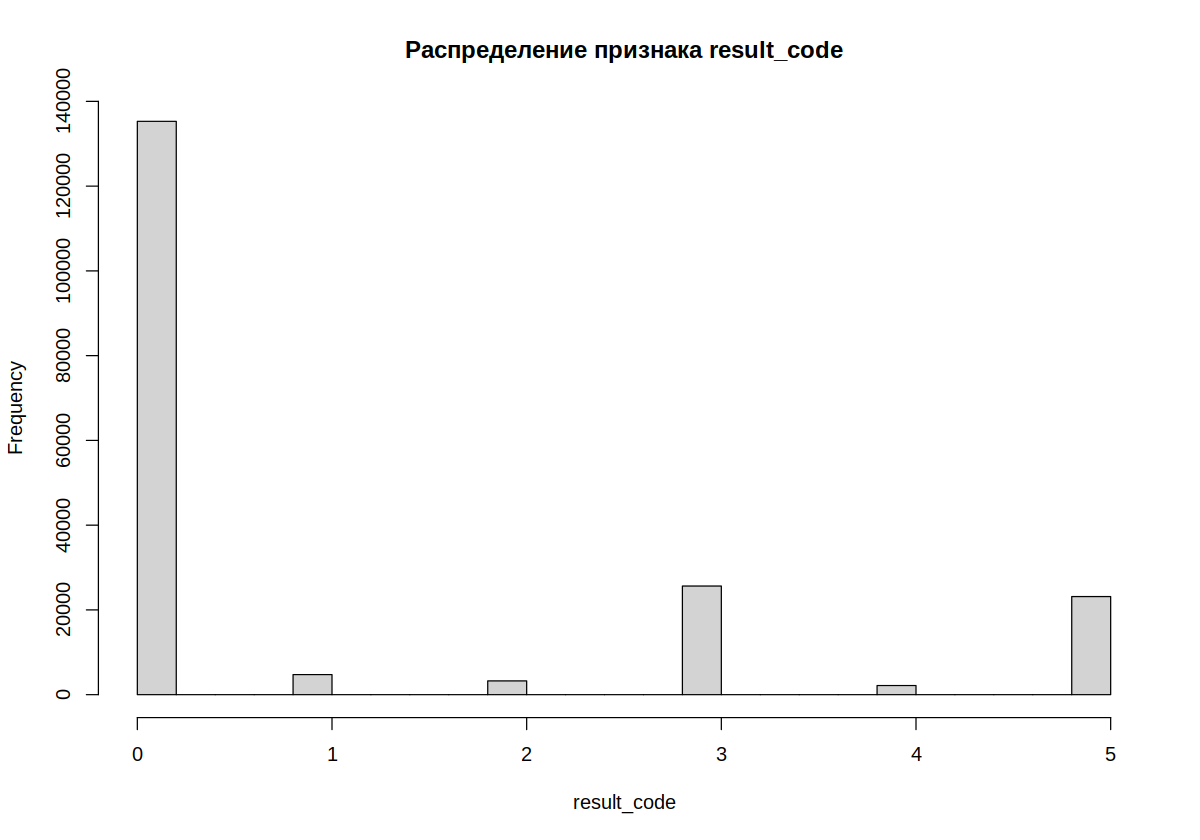

In [3]:
hist(data$result_code, xlab = 'result_code', 
    main='Распределение признака result_code')

Из попарного сравнения равенства трех переменных `regno_recognize` ($x_1$), `regno_ai`  ($x_2$) и `regno` ($x_3$) мы можем сделать ровно 5 непересекающихся групп наблюдений. Обозначим, допустим, так:

$x_1=x_2$|$x_2=x_3$|тогда $x_3=x_1$|Обозначим этот случай|Интерпретация для кода 0
:---:|:---:|:---:|:---:|:---:
T|T|T|TTT|`op` не менял `cam` (`cam` прав, `ai` прав)
F|T|F|FTF|`op` менял `cam` на `ai` (`cam` не прав, `ai` прав)
T|F|F|TFF|`op` менял `cam` на что-то (`cam` = `ai` оба не правы)
F|F|T или F|FFT или FFF|T: `op` не менял `cam` (`cam` прав, `ai` не прав) **или** F: `op` менял `cam` на что-то (`cam` != `ai` оба не правы)

Добавим такие переменные, чтобы было удобнее по ним фильтровать.

In [4]:
c(  "TTT" = "ai = cam = op",
    "FTF" = "(ai = op) != cam",
    "TFF" = "(ai = cam) != op",
    "FFT" = "ai != (cam = op)",
    "FFF" = "ai != cam != op"
) -> details

data[, cam.ai   := (regno_recognize == regno_ai)]
data[, ai.op    := (regno_ai == regno)]
data[, op.cam   := (regno == regno_recognize)]
data[, kind     := as.factor(gsub("FALSE", "F", gsub("TRUE", "T", paste0(cam.ai, ai.op, op.cam))))]
data[, details  := as.factor(details[as.character(kind)])]

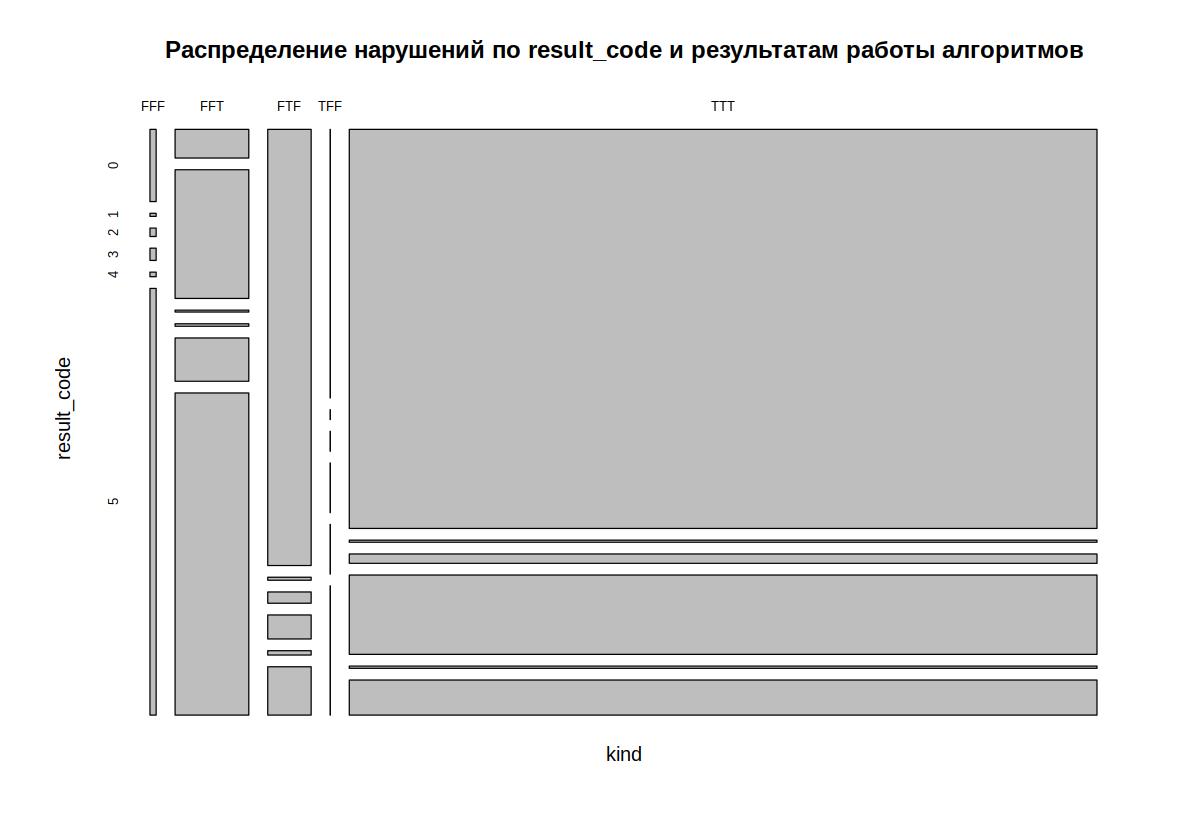

In [5]:
mosaicplot(~ kind + result_code, data=data, 
    main='Распределение нарушений по result_code и результатам работы алгоритмов')

In [6]:
with(data, table(cam.ai, result_code))

with(data, table(ai.op, result_code))

with(data, table(op.cam, result_code))

with(data, table(details, result_code))

       result_code
cam.ai       0      1      2      3      4      5
  FALSE   9088   4074    288    552   1441  12045
  TRUE  126201    662   2962  25079    714  11108

       result_code
ai.op        0      1      2      3      4      5
  FALSE   1108   4020     83    116   1366  11170
  TRUE  134181    716   3167  25515    789  11983

       result_code
op.cam       0      1      2      3      4      5
  FALSE   8223     64    231    478     97   2018
  TRUE  127066   4672   3019  25153   2058  21135

                  result_code
details                 0      1      2      3      4      5
  (ai = cam) != op     27      1      2      5      5     13
  (ai = op) != cam   8007     55    207    441     80    888
  ai != (cam = op)    892   4011     59     79   1349  10040
  ai != cam != op     189      8     22     32     12   1117
  ai = cam = op    126174    661   2960  25074    709  11095

Вероятность, что `op` будет исправлять результат алгоритма `cam` (группировка по финальному коду):   

- исправление ГРЗ оператором по финальному коду (11111 раз), из них совпало с новым алгоритмом (9678 раз)   
- можем оценить вероятность, что `ai` распознает ГРЗ одинаковым образом с `op` в классе наблюдений, по которым оператор обычно вносит исправления в ГРЗ (0.8710287)   
- хуже всего новый алгоритм справляется в случае `result_code = 5` (иное) - доля корректных исправлений ошибок алгоритма `cam` совпала с фактическими исправлениям оператора только в 44% случаев.   

In [7]:
op.corr.cam <- as.data.frame.matrix(with(data, table(result_code, op.cam)))
op.corr.cam  <- cbind(op.corr.cam , with(data, table(result_code, details))[, "(ai = op) != cam"])
colnames(op.corr.cam) <- c("cam.false", "total", "op.eq.ai")
op.corr.cam <- op.corr.cam[c(2,1,3)]
op.corr.cam <- rbind(op.corr.cam, colSums(op.corr.cam))

op.corr.cam$q.cam <- with(op.corr.cam, cam.false/total)
op.corr.cam$`±95% cam` <- apply(op.corr.cam, 1, 
                                function(x) diff(binom.test(x[2], x[1])$conf.int) / 2)

op.corr.cam$`ai.T|cam.F` <- with(op.corr.cam, op.eq.ai/cam.false)
op.corr.cam$`±95% ai` <- apply(op.corr.cam, 1, 
                               function(x) diff(binom.test(x[2], x[1])$conf.int) / 2)

is.num <- sapply(op.corr.cam, is.numeric)
op.corr.cam[is.num] <- lapply(op.corr.cam[is.num], round, 3)

op.corr.cam

,total,cam.false,op.eq.ai,q.cam,±95% cam,ai.T|cam.F,±95% ai
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,127066,8223,8007,0.065,0.001,0.974,0.001
1,4672,64,55,0.014,0.003,0.859,0.003
2,3019,231,207,0.077,0.010,0.896,0.010
3,25153,478,441,0.019,0.002,0.923,0.002
4,2058,97,80,0.047,0.009,0.825,0.009
5,21135,2018,888,0.095,0.004,0.440,0.004
7,183103,11111,9678,0.061,0.001,0.871,0.001


Тем не менее, сколько раз новый алгорим верно подсказал ГРЗ в сегменте финальных кодов 1-5 **в целом** по генеральной совокупности мы оценить не можем, т.к.   

- мы не можем в этом случае, исходя из постановки задачи, считать окончательный ГРЗ истинным  
- 95% доверительные интервалы для вероятностей нигде не пересекаются ($n$ достаточно большие, поэтому дов.интервалы узкие) - гипотеза об однородности отвергается для всех групп (mosaicplot подтверждает это графически)  
- не зная предметную область строить какие-то еще гипотезы в этой части бессмысленно  

Напрашивается вывод, что нужно ограничиться только `result_code = 0`.

### <a id='toc1_3_'></a>[По времени и камерам](#toc0_)

Время из строки переводится во внутренний формат времени `data.table`

In [8]:
data[, time_check := as.ITime(time_check)]

Распределение в течение суток обработки нарушений в части ошибок алгоритма `cam` в разбивке по результирующим кодам обработки:  
  
- `FALSE` - опрератор исправлял ГРЗ, предложенный `cam`, `TRUE` - оператор согласился с алгоритмом `cam`   
- интерес представляют в основном данные по `result_code = 0`  
    - чаще всего алгоритм `cam` ошибается вечером (20:00-24:00)  
    - остальные картинки любопытные, но к задаче прямого отношения не имеют  

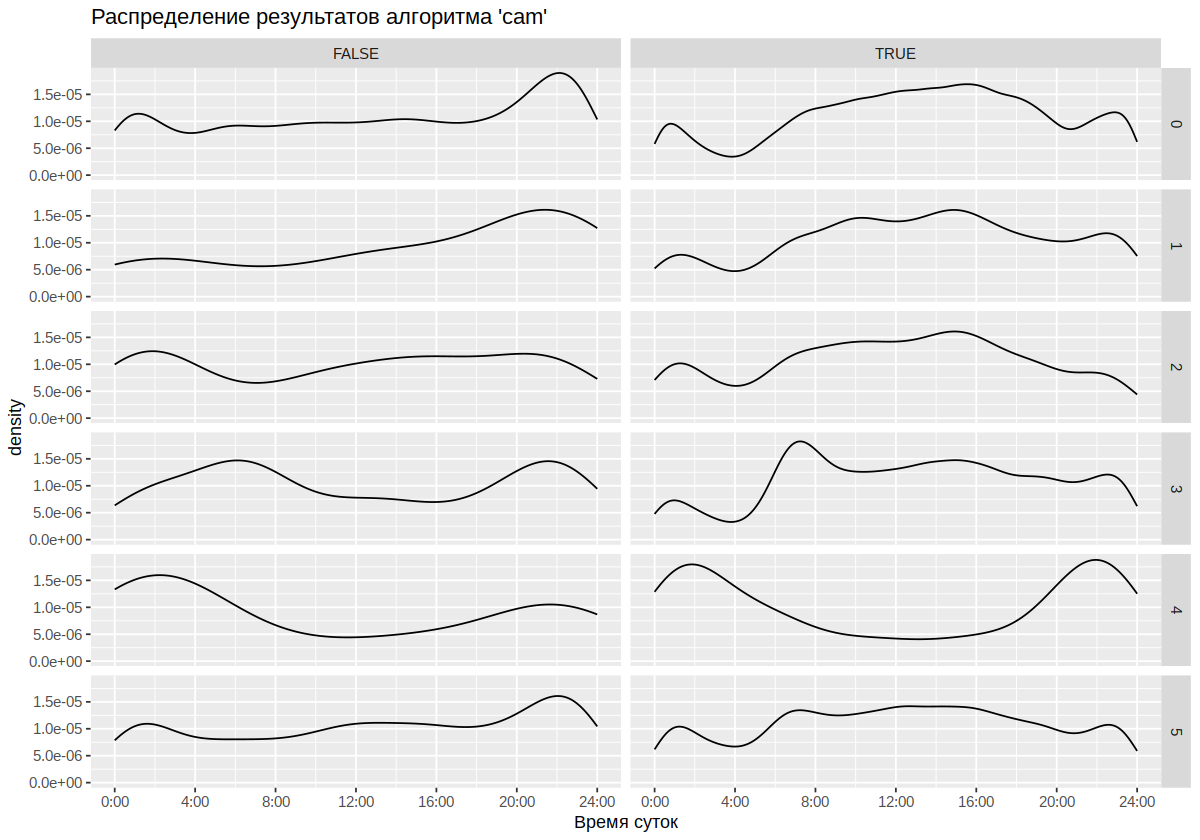

In [9]:
ggplot(data, aes(x = as.numeric(time_check))) + 
    geom_density() +
    scale_x_continuous(name = "Время суток", 
                   breaks = seq(0, 24*60*60, 4*60*60), 
                   limits = c(0, 24*60*60), 
                   labels = paste0(seq(0, 24, 4), ":00")) +
    facet_grid(result_code ~ op.cam) + 
    ggtitle("Распределение результатов алгоритма 'cam'")

Форма распределения ошибочного срабатывания алгоритма `ai` сильно отличается:   
- они почти равномерно распределены по нарушениям, происходящим в течение рабочего времени (9:00-18:00)  
- с небольшими подъемам в 9:00 и 18:00  

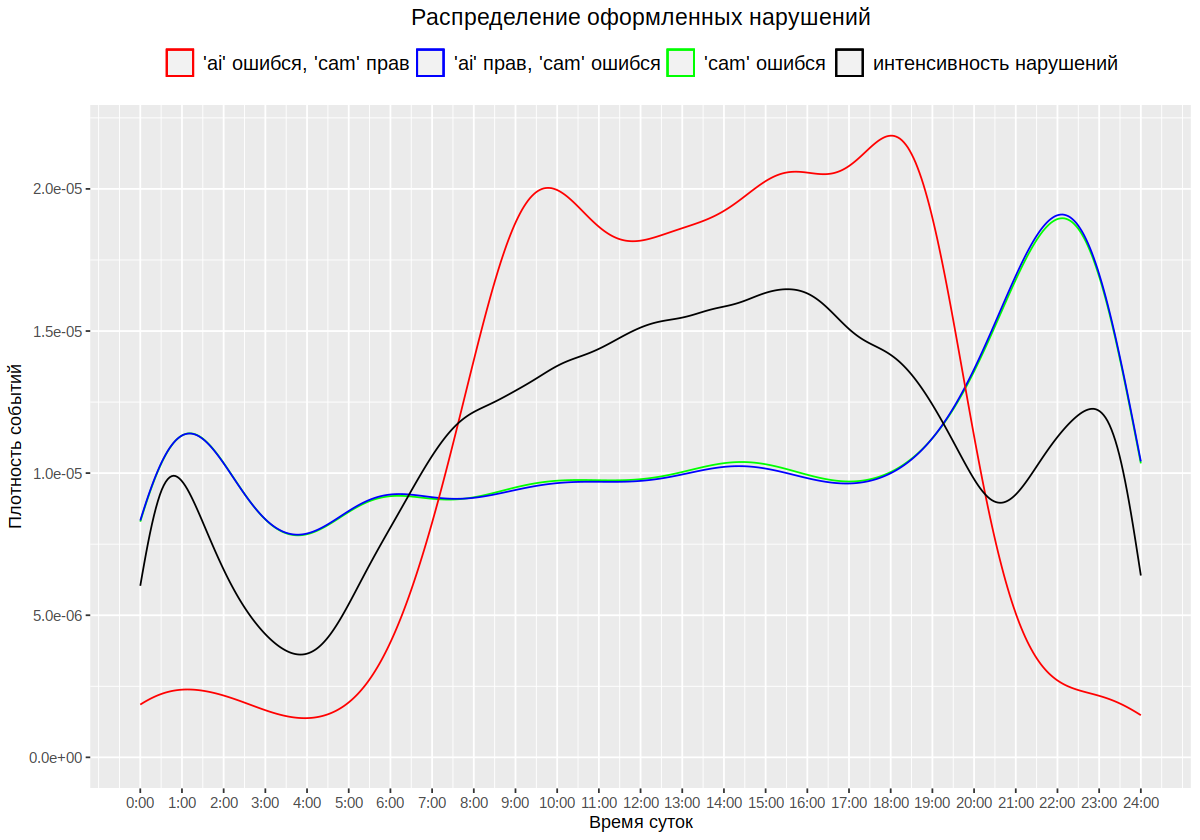

In [10]:
ggplot() + 
    geom_density(data=data[(result_code == 0) & !op.cam], 
                 aes(x = time_check, colour = "'cam' ошибся")) + 
    geom_density(data=data[(result_code == 0) & (details == "(ai = op) != cam")], 
                 aes(x = time_check, colour = "'ai' прав, 'cam' ошибся")) + 
    geom_density(data=data[(result_code == 0) & (details == "ai != (cam = op)")], 
                 aes(x = time_check, colour = "'ai' ошибся, 'cam' прав")) + 
    geom_density(data=data[(result_code == 0)], 
                 aes(x = time_check, colour = "интенсивность нарушений")) + 
    scale_x_continuous(name = "Время суток", 
                       breaks = seq(0, 24*60*60, 60*60), 
                       limits = c(0, 24*60*60), 
                       labels = paste0(c(0:24), ":00")) + 
    scale_y_continuous(name = "Плотность событий") +
    scale_colour_manual(name = "",
                       values = c("интенсивность нарушений" = "black", 
                                  "'ai' прав, 'cam' ошибся" = "blue", 
                                  "'ai' ошибся, 'cam' прав" = "red",
                                  "'cam' ошибся"            = "green")) + 
    ggtitle("Распределение оформленных нарушений") + 
    theme(plot.title = element_text(size = 14, hjust = 0.5),
          legend.direction = "horizontal", 
          legend.position = "top",
          legend.text=element_text(size=12))

Форма распределения корректного исправления ошибок алгоритма `cam` алгоритмом `ai` до неразличимости повторяет само распределение ошибок алгоритма `cam`  

Как распределены нарушения по `camera_id`. 

In [11]:
cam.data <- data[, .(
    viols = .N, 
    rc0 = sum(result_code == 0),
    rc0.cam.err = sum((result_code == 0) & !op.cam), 
    rc0.ai.err = sum((result_code == 0) & !ai.op), 
    rc0.ai.err.cam.win = sum((result_code == 0) & !ai.op & op.cam), 
    rc0.ai.win = sum((result_code == 0) & (details == "(ai = op) != cam"))
), by=camera_id][order(-viols)]


Всего 971 различных `camera_id`.

In [12]:
data$camera_id %>% unique %>% length

[1] 971

511 из 892 (57%) ошибок алгоритма `ai`, когда при этом прав оказался алгоритм `cam`, пришлись на 10 камер из 971 (1%):  
  
- в сумме эти 10 камер обработали 9255 из 135289 нарушений (6,8%)  
- их этих 10 камер в топ-10 по загруженности входят только 3  

In [13]:
cam.data[order(-rc0.ai.err.cam.win)] %>% head(10) %>% colSums

camera_id              viols                rc0        rc0.cam.err 
             33393              10819               9255                404 
        rc0.ai.err rc0.ai.err.cam.win         rc0.ai.win 
               552                511                363

Можно сделать вывод, что ошибочное решение алгоритма `ai` при признании верным решения алгоритма `cam` коррелирует с:   
  
- временем фиксации нарушения  
- местом фиксации нарушения

### <a id='toc1_4_'></a>[По алфавиту](#toc0_)

Алфавиты, используемые алгоритмами, также отличаются:  
  
- алфавит алгоритма `cam` кроме разрешенных символов включает латиницу и `_`  
- алфавит алгоритма `ai` включает кроме разрешенных символов также символ `D`  

In [14]:
data$regno_recognize %>% strsplit("") %>% unlist %>% unique %>% sort
data[(result_code == 0)]$regno %>% strsplit("") %>% unlist %>% unique %>% sort
data$regno_ai %>% strsplit("") %>% unlist %>% unique %>% sort

[1] "_" "0" "1" "2" "3" "4" "5" "6" "7" "8" "9" "А" "Б" "В" "Г" "Е" "К" "М" "Н"
[20] "О" "Р" "С" "Т" "У" "Х" "D" "F" "G" "I" "J" "L" "N" "Q" "R" "S" "U" "V" "W"
[39] "Z"

[1] "0" "1" "2" "3" "4" "5" "6" "7" "8" "9" "А" "В" "Е" "К" "М" "Н" "О" "П" "Р"
[20] "С" "Т" "У" "Х" "Ц" "D" "I"

[1] "0" "1" "2" "3" "4" "5" "6" "7" "8" "9" "А" "В" "Е" "К" "М" "Н" "О" "Р" "С"
[20] "Т" "У" "Х" "D"

## <a id='toc2_'></a>[Модель](#toc0_)

Исходя из постановки задачи определить насколько корректно был распознан ГРЗ алгоритмом `cam` и алгоритмом `ai` мы может только в классе наблюдений `result_code=0` (оператор просмотрел материал, если надо исправил ГРЗ,   убедился, что исправленый ГРЗ верный, оформил нарушение). Мы принимаем такие значения `regno` за истинное значение ГРЗ (с погрешностью равной погрешности работы оператора, которую не оцениваем и не учитываем). 
  
В иных классах финальных кодов обработки нарушений мы не можем оценить эффективность работы алгоритмов. Это связано в том числе с широтой возможных интерпретаций причин для забраковки материалов, указанных в   `result_code`.
  
Как было показано выше, на выборке из 135289 оформленных нарушений алгоритм `ai` 8007 раз верно и 892 раз ошибочно исправил результат работы алгоритма `cam`.  
Всего же алгоритм `ai` ошибся 1108 раз на 135289 оформленных нарушений ($q_{ai} = 0.0083$).  
  
Чтобы еще сильнее уменьшить вероятность ошибки за счет совместной работы алгоритмов `ai` и `cam`, можно построить бинарный классификатор $C$, выделяющий в наблюдениях класс, соответствующий упомянутым 892 наблюдениям,   где алгоритм `ai` ошибся, а алгоритм `cam` показал верный результат, и использовать алгоритм `cam` при отнесении наблюдения к этому классу.
  
Пусть $X$ - вектор независимых переменных, $y$ - метка класса, $\hat y$ - предсказанная метка класса, $s$ - распознанный ГРЗ.  
  
Пусть вероятности успеха/неудачи алгоритмов:   
  
$$s = Ai(X): p_{ai}, q_{ai} = 1 - p_{ai}$$

$$s = Cam(X): p_{cam}, q_{cam} = 1 - p_{cam}$$  
  
Пусть параметры качества классификатора $C(X) \rightarrow \hat y \in \{0,1\}: TP, TN, FP, FN$.  
  
Правило $F$:   

$$
s = F(X) =
\begin{cases}
    Ai(X), & \text{if } C(X) = \hat y = 0
    \\
    Cam(X), & \text{if } C(X) = \hat y = 1
\end{cases}
$$

Тогда ожидаемый эффект (вероятность правильной классификации) такого правила будет:

$$p_{F} = \frac{TN \cdot (p_{ai}|y=0) + FN \cdot (q_{ai}|y=0) + TP \cdot (p_{cam}|y=1) + FP \cdot (q_{cam}|y=1)}{TP + TN + FP + FN}$$

### <a id='toc2_1_'></a>[Выделим целевой класс](#toc0_)

... и посмотрим, что туда попало.

In [16]:
data[, target := ifelse((result_code == 0)&!ai.op&op.cam, 1, 0)] 

data[(target == 1)] %>% nrow

[1] 892

После беглого взгляда на данные становится понятно, что алгоритм `ai` не умеет распознавать ГРЗ определенного вида: *4 цифры 2 буквы 2 цифры* (кажется, это **прицепы**, так и будем их обозначать):  
  
- в целевом классе 764 из 892 ГРЗ такого типа  
- как показано выше, такие ГЗР совершают нарушения   
    - в основном в рабочее время   
    - под примерно одними и теми же камерами  

In [17]:
pricep <- "^[0-9]{4}[А-Я|A-Z]{2}[0-9]{2}$"

grepl(pricep, data[(target == 1)]$regno) %>% sum

[1] 764

Общая статистика работы алгоритмов по нарушениям "прицепов" наглядно это подтверждает:   
   
- 1128 `cam` распознал ГРЗ как "прицепы"   
- 1002 раз нарушение оформлено с ГРЗ типа "прицепа", в т.ч. 983 из них опознаны как "прицепы" алгоритмом `cam`, из них    
    - `cam` правильно распознал 955 (неправильно 28)   
    - `ai` правильно распознал 193 (неправильно 790)   

In [18]:
grepl(pricep, data[(result_code == 0)]$regno) %>% sum

pricep.stats <- data.frame(
  "Распознано" = grepl(pricep, data$regno_recognize) %>% sum,
  "Оформлено"  = grepl(pricep, data[(result_code == 0)]$regno_recognize) %>% sum, 
  "p.ai"       = grepl(pricep, data[(result_code == 0) & ai.op]$regno_recognize) %>% sum, 
  "q.ai"       = grepl(pricep, data[(result_code == 0) & !ai.op]$regno_recognize) %>% sum, 
  "p.cam"      = grepl(pricep, data[(result_code == 0) & op.cam]$regno_recognize) %>% sum,
  "q.cam"      = grepl(pricep, data[(result_code == 0) & !op.cam]$regno_recognize) %>% sum
)

pricep.stats

[1] 1002

Распознано,Оформлено,p.ai,q.ai,p.cam,q.cam
<int>,<int>,<int>,<int>,<int>,<int>
1128,983,193,790,955,28


## <a id='toc3_'></a>[Решение](#toc0_)

Разделим данные по паттерну "прицепа" в ГРЗ, распознанном алгоритмом `cam`. Получим статистику работы алгоритмов в таком разрезе.

In [19]:
data[, target := grepl(pricep, data$regno_recognize)]

with(data[(result_code == 0)], table(ai.op, target))
with(data[(result_code == 0)], table(op.cam, target))

       target
ai.op    FALSE   TRUE
  FALSE    318    790
  TRUE  133988    193

       target
op.cam   FALSE   TRUE
  FALSE   8195     28
  TRUE  126111    955

То что в модели обозначили классификатором в данном случае - просто правило, для которого $C(X): FP=FN=0$. Поэтому эффективность такого правила - это средневзвешенная по классам эффективность исходных алгоритмов.

$$p_F = \frac {133988 + 955}{133988 + 318 + 955 + 28} = 0.99744$$

$$q_F = 1 - p_F = 0.00255$$

Отсюда можем сформулировать уточненное решение задачи:  
  
1. Заменяем ГРЗ на распознанный новым алгоритмом, когда **в распознанном старым алгоритмом ГРЗ отсутстует паттерн ГРЗ "прицепа"** (4 цифры 2 буквы 2 цифры).  
2. Это обусловлено тем, что в целом более эффективный новый алгоритм, допускает в 790/28 = 28 раз больше ошибок в таких ГРЗ.   
3. Качество работы такого правила - экономия 8223 - 318 - 28 = 7877 операций по ручному уточнению ГРЗ (в расчете на 135289 оформленых нарушения).  

### <a id='toc3_1_'></a>[Проверка](#toc0_)
  
Проверим, можно ли еще больше сократить этот показатель, использовав информацию о распределении данных нарушений в течение суток

- ошибка ансабля алгоритмов `ai`+`cam` распределена близко к средней интенсивности нарушений  

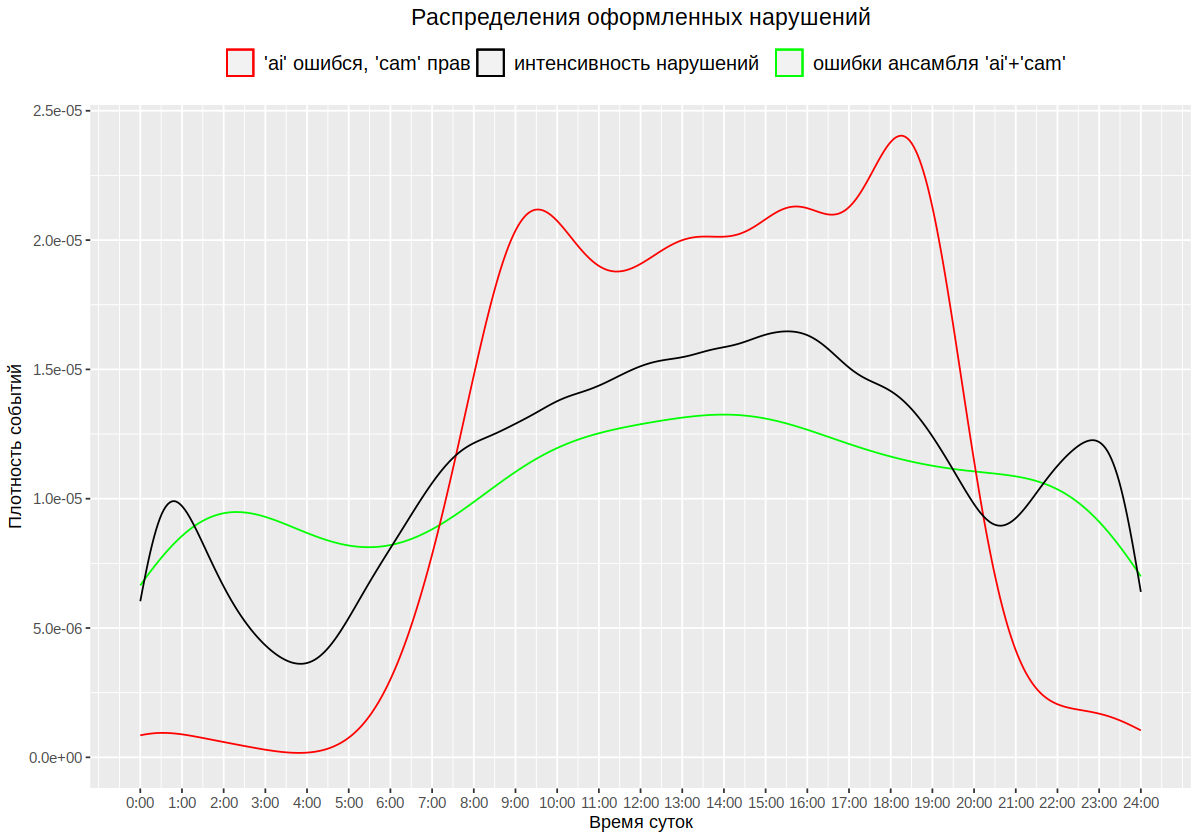

In [20]:
ggplot() + 
    geom_density(data=data[(result_code == 0)&((target&!op.cam)|(!target&!ai.op))], 
                 aes(x = time_check, colour = "ошибки ансамбля 'ai'+'cam'")) + 
    geom_density(data=data[(result_code == 0)&(target)], 
                 aes(x = time_check, colour = "'ai' ошибся, 'cam' прав")) + 
    geom_density(data=data[(result_code == 0)], 
                 aes(x = time_check, colour = "интенсивность нарушений")) + 
    scale_x_continuous(name = "Время суток", 
                       breaks = seq(0, 24*60*60, 60*60), 
                       limits = c(0, 24*60*60), 
                       labels = paste0(c(0:24), ":00")) + 
    scale_y_continuous(name = "Плотность событий") +
    scale_colour_manual(name = "", 
                        values = c("интенсивность нарушений"    = "black", 
                                   "ошибки ансамбля 'ai'+'cam'" = "green", 
                                   "'ai' ошибся, 'cam' прав"    = "red")) + 
    ggtitle("Распределения оформленных нарушений") + 
    theme(plot.title = element_text(size = 14, hjust = 0.5),
          legend.direction = "horizontal", 
          legend.position = "top",
          legend.text=element_text(size=12))